In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_plotting_accelerometer, utils_accelerometer, utils_misc

from lib_accelerometer import ACCELEROMETER 
from lib_data import DATA_IO
from lib_statistics import NON_PARAMETRIC_TEST

In [2]:
PATH_CURR   = os.path.abspath(os.curdir)    # current code
PATH        = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
SUB_LIST    = utils_misc.get_SUB_list(DATA_IO.path_data) # get the SUB id list which we have a recording of them

# 1. Load accelerometer event history of all patient
df_accelerometer_events = pd.read_csv(DATA_IO.path_events + "EVENTS_ACC.csv")

In [ ]:
accelerometer_events = pd.DataFrame()

for SUB in SUB_LIST: 
    
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    patient_acc_events = patient_kinematics.extract_accelerometer_events(patient_events)

    # If the accelerometer events dictionary is empty assign the patient event dictionary to it
    if(len(accelerometer_events)==0):
        accelerometer_events = patient_acc_events

    # otherwise, merge previous patient events with current patient events 
    else:
        accelerometer_events = utils_misc.combine_dataframes(accelerometer_events, patient_acc_events)

ACCELEROMETER: SUB-008
... loading started
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_left.P


In [ ]:
accelerometer_events.to_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")

# 1. Plot Event Categories

In [25]:
accelerometer_events = pd.read_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")

# removing irregular dyskinesia scores
accelerometer_events = accelerometer_events[(~accelerometer_events['dyskinesia_total'].isnull()) & (accelerometer_events['event_category']=="voluntary")]

# removing uncontinious events due to the artifect removal 
accelerometer_events = accelerometer_events[accelerometer_events.duration== (accelerometer_events.event_finish_index-accelerometer_events.event_start_index)/512]

## 1. Tapping Events - LID vs no-LID

<Figure size 640x480 with 0 Axes>

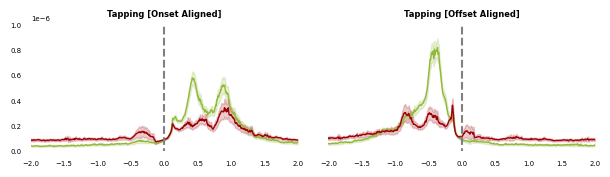

In [26]:
utils_plotting_accelerometer.plot_accelerometer_events_for_event_category(accelerometer_events, event_category="voluntary", 
                                                                          figure_name=DATA_IO.path_figure + "tapping_onset_vs_offset")

In [27]:
import utils_plotting

def plot_accelerometer_events(data, color, axis, error_bar= "se"):

    if(len(data)!=0):
        
        assert error_bar in ["sd", "se"], f'Please choose error bar as standard deviation:"sd" or standard error: "se"'
        
        # Compute the mean and error_bar (standard deviation or standard error)
        mean_data   = np.mean(data, axis=0)

        # define upper and lower bondaries of y axis
        y_axis_upper = max(mean_data) * 1.25
        y_axis_lower = min(mean_data) * 1.25
    
        if(error_bar=="sd"):
            error       = np.std(data, axis=0)
            error_label = "standard deviation"
        elif(error_bar=="se"):
            error       = 2 * np.std(data, axis=0) / np.sqrt(len(data))
            error_label = "standard error"

        t  = np.linspace(-2, 2, 4*512)
        # plot
        axis.plot(t, mean_data, label='mean', c=color, linewidth=1)
        axis.fill_between(t, mean_data - error, mean_data + error, alpha=0.2, color=color, label=error_label)
        axis.grid(False)
        axis.set_ylim([y_axis_lower, y_axis_upper])
        
        return axis
    else:
        return axis

In [28]:
def plot_accelerometer_events_for_dyskinesia_severity(dataset, event_category, dyskinesia_strategy, figure_name):

    plt  = utils_plotting.get_figure_template()
    ax1  = plt.subplot2grid((75, 40), (0, 0)  , colspan=19, rowspan=15)
    ax2  = plt.subplot2grid((75, 40), (0, 21) , colspan=19, rowspan=15)

    if(dyskinesia_strategy == "total"):
        
        for severity in accelerometer_events.dyskinesia_total.unique():
            dataset_severity        = dataset[(dataset.event_category == event_category) & (dataset.dyskinesia_total == severity)]
            dataset_severity_onset  = []
            dataset_severity_offset = []
    
            for index, row in dataset_severity.iterrows():
                dataset_severity_onset.append(row["event_onset_aligned"])
                dataset_severity_offset.append(row["event_offset_aligned"])

            ax1  = plot_accelerometer_events(dataset_severity_onset , axis=ax1, color=utils_plotting.colors[event_category][severity])
            ax2  = plot_accelerometer_events(dataset_severity_offset, axis=ax2, color=utils_plotting.colors[event_category][severity])

    else:
        
        for severity in accelerometer_events.dyskinesia_arm.unique():
            dataset_severity        = dataset[(dataset.event_category == event_category) & (dataset.dyskinesia_arm == severity)]
            dataset_severity_onset  = []
            dataset_severity_offset = []
    
            for index, row in dataset_severity.iterrows():
                dataset_severity_onset.append(row["event_onset_aligned"])
                dataset_severity_offset.append(row["event_offset_aligned"])

            ax1  = plot_accelerometer_events(dataset_severity_onset , axis=ax1, color=utils_plotting.colors[event_category][severity])
            ax2  = plot_accelerometer_events(dataset_severity_offset, axis=ax2, color=utils_plotting.colors[event_category][severity])

        
    utils_plotting.set_axis(ax1)
    utils_plotting.set_axis(ax2)

    ax1.set_title("Tapping [Onset Aligned]", fontsize=utils_plotting.LABEL_SIZE_label, weight="bold")
    ax2.set_title("Tapping [Offset Aligned]", fontsize=utils_plotting.LABEL_SIZE_label, weight="bold")
    
    ax1.axvline(x=0, ymin=-1, ymax=1, ls='--', color="grey")
    ax2.axvline(x=0, ymin=-1, ymax=1, ls='--', color="grey")
    ax1.set_xlim([-2,2])
    ax2.set_xlim([-2,2])
    ax1.set_ylim([0, 1e-06])
    ax2.set_ylim([0, 1e-06])

    ax2.set_yticklabels("")
    plt.savefig(figure_name + ".png", dpi=300)
    plt.savefig(figure_name + ".svg", dpi=300)

<Figure size 640x480 with 0 Axes>

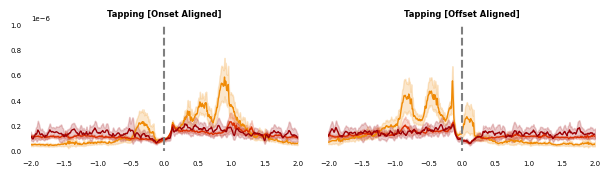

In [29]:
plot_accelerometer_events_for_dyskinesia_severity(accelerometer_events[accelerometer_events.dyskinesia_arm!="none"], 
                                                  event_category="voluntary", dyskinesia_strategy="arm",
                                                  figure_name=DATA_IO.path_figure + "tapping_dyskinesia_severity_arms")

<Figure size 640x480 with 0 Axes>

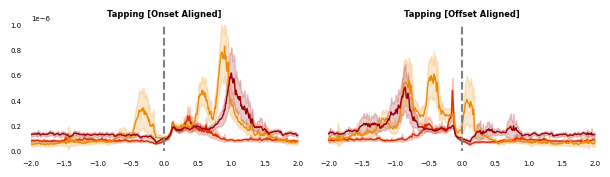

In [30]:
plot_accelerometer_events_for_dyskinesia_severity(accelerometer_events[accelerometer_events.dyskinesia_total!="none"], 
                                                  event_category="voluntary", dyskinesia_strategy="total",
                                                  figure_name=DATA_IO.path_figure + "tapping_dyskinesia_severity_total")

# 2. Extract Temporal Metrics for Event Segments

In [ ]:
df_accelerometer_features = pd.DataFrame()

for SUB in SUB_LIST: 
    # get individual patient kinematics and corresponding events
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    # extract 
    df_patient_accelerometer_features, feat_temporal = patient_kinematics.extract_temporal_metrics_from_event_segments(patient=SUB, event_dataframe=patient_events)

    if(len(df_accelerometer_features)==0): # if the dataframe is empty
        df_accelerometer_features = df_patient_accelerometer_features
    else:
        df_accelerometer_features = pd.concat([df_accelerometer_features, df_patient_accelerometer_features], ignore_index=True)


## 2.1 Comparison Between Tappping vs Involuntary Movements

In [ ]:
kw_test   = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features, group_variable="event_category", 
                                                feature_set=feat_temporal, subset_variable="event_segment")

dunn_test = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features, group_variable="event_category", 
                                          feature_set=feat_temporal, subset_variable="event_segment")

## 2.2 Comparison for Tapping Between Different Dyskinesia Severity Scores

In [ ]:
kw_test_tapping   = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features[df_accelerometer_features.event_category=="tapping"], 
                                                        group_variable="dyskinesia_severity", 
                                                        feature_set=feat_temporal, subset_variable="event_segment")

dunn_test_tapping = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features[df_accelerometer_features.event_category=="tapping"], 
                                                  group_variable="dyskinesia_severity", 
                                                  feature_set=feat_temporal, subset_variable="event_segment")

## 2.3 Comparison for Involuntary Movement Between Different Dyskinesia Severity Scores

In [ ]:
kw_test_involuntary_move = NON_PARAMETRIC_TEST.kruskall_wallis(df_accelerometer_features[df_accelerometer_features.event_category=="involuntary_movement"], 
                                                               group_variable="dyskinesia_severity", 
                                                               feature_set=feat_temporal, subset_variable="event_segment")

dunn_test_involuntary_move = NON_PARAMETRIC_TEST.dunn_test(df_accelerometer_features[df_accelerometer_features.event_category=="involuntary_movement"], 
                                                           group_variable="dyskinesia_severity", 
                                                           feature_set=feat_temporal, subset_variable="event_segment")

In [ ]:
x = [df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_none")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_mild")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_moderate")].duration.to_list(),
     df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_severe")].duration.to_list()]

In [ ]:
df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_none")].duration.median()

In [ ]:
df_accelerometer_features[(df_accelerometer_features.event_segment=="event") &
                               (df_accelerometer_features.event_category=="tapping") &
                               (df_accelerometer_features.dyskinesia_severity=="LID_mild")].duration.median()

In [ ]:
sp.posthoc_dunn(x, p_adjust = 'holm')

In [ ]:
dunn_test_tapping[(dunn_test_tapping.feature == "duration") & (dunn_test_tapping.event_segment == "event")]

In [ ]:
feat_temporal

In [ ]:
dunn_test_tapping[(dunn_test_tapping.event_segment == "event")]

# 3. Figure Generation

In [42]:
def boxplot(data, feat_x, feat_y, hue, axis, color_palette, ylabel):
    axis = sns.boxplot(data=data, x=feat_x, y=feat_y, hue=hue, palette= color_palette, showfliers=False, ax=axis, legend=False)
    axis.set_xlabel("")
    axis.set_ylabel(ylabel, fontsize=utils_plotting_accelerometer.LABEL_SIZE)
    axis.legend(loc="lower center", fontsize=utils_plotting_accelerometer.LABEL_SIZE, 
                bbox_to_anchor=(0.5, -0.6), title=None, ncol=2, frameon=False)
    return axis

def count_plot(data, feat_x, hue, axis, color_palette):
    axis = sns.countplot(data, x=feat_x, hue=hue, orient="h", palette=color_palette, ax=axis)
    axis.set_xlabel("")
    axis.set_title(feat_x, fontsize=utils_plotting_accelerometer.LABEL_SIZE, weight="bold")
    axis.legend(loc="lower center", fontsize=utils_plotting_accelerometer.LABEL_SIZE, 
                bbox_to_anchor=(0.5, -0.5), title=None, ncol=2, frameon=False)
    return axis

In [ ]:
plt = utils_plotting_accelerometer.get_figure_template()

ax1  = plt.subplot2grid((75, 50), (0, 0), colspan=5, rowspan=13)
ax2  = plt.subplot2grid((75, 50), (0, 10), colspan=5, rowspan=13)
ax3  = plt.subplot2grid((75, 50), (0, 20), colspan=5, rowspan=13)

ax4  = plt.subplot2grid((75, 50), (20, 0), colspan=5, rowspan=13)
ax5  = plt.subplot2grid((75, 50), (20, 10), colspan=5, rowspan=13)
ax6  = plt.subplot2grid((75, 50), (20, 20), colspan=5, rowspan=13)

ax7  = plt.subplot2grid((75, 50), (40, 0), colspan=5, rowspan=13)
ax8  = plt.subplot2grid((75, 50), (40, 10), colspan=5, rowspan=13)
ax9  = plt.subplot2grid((75, 50), (40, 20), colspan=5, rowspan=13)

ax10 = plt.subplot2grid((75, 50), (60, 25), colspan=25, rowspan=6)
ax11 = plt.subplot2grid((75, 50), (70, 25), colspan=25, rowspan=6)

ax1 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax1, 
              color_palette=colors_tapping, ylabel="peak")

ax2 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax2, 
              color_palette=colors_tapping, ylabel="peak_location")

ax3 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="pre")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax3, 
              color_palette=colors_tapping, ylabel="mean")

ax4 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax4, 
              color_palette=colors_tapping, ylabel="peak")

ax5 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax5, 
              color_palette=colors_tapping, ylabel="peak_location")

ax6 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="event")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax6, 
              color_palette=colors_tapping, ylabel="mean")

ax7 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="peak", hue="dyskinesia_severity", axis=ax7, 
              color_palette=colors_tapping, ylabel="peak")

ax8 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="peak_location", hue="dyskinesia_severity", axis=ax8, 
              color_palette=colors_tapping, ylabel="peak_location")

ax9 = boxplot(df_accelerometer_features[(df_accelerometer_features.event_category=="tapping") & (df_accelerometer_features.event_segment=="post")],
              feat_x="dyskinesia_severity", feat_y="mean", hue="dyskinesia_severity", axis=ax9, 
              color_palette=colors_tapping, ylabel="mean")


ax10 = boxplot(df_accelerometer_events[df_accelerometer_events.event_category=="tapping"],
              feat_y="event_category", feat_x="duration", hue="dyskinesia_score", axis=ax10, 
              color_palette=colors_tapping, ylabel="duration (sec)")

ax11 = boxplot(df_accelerometer_events[df_accelerometer_events.event_category=="involuntary_movement"],
              feat_y="event_category", feat_x="duration", hue="dyskinesia_score", axis=ax11, 
              color_palette=colors_invol_m, ylabel="duration (sec)")

#ax3.set_xlim([0,20])
#ax4.set_xlim([0,20])

utils_plotting_accelerometer.set_axis(ax1)
utils_plotting_accelerometer.set_axis(ax2)
utils_plotting_accelerometer.set_axis(ax3)
utils_plotting_accelerometer.set_axis(ax4)
utils_plotting_accelerometer.set_axis(ax5)
utils_plotting_accelerometer.set_axis(ax6)
utils_plotting_accelerometer.set_axis(ax7)
utils_plotting_accelerometer.set_axis(ax8)
utils_plotting_accelerometer.set_axis(ax9)
utils_plotting_accelerometer.set_axis(ax10)
utils_plotting_accelerometer.set_axis(ax11)
plt.savefig("pff.svg", dpi=300)

In [ ]:
df_accelerometer_features